# 第 6  章  数据加载、存储与文件格式

访问数据是使用本书所介绍的这些工具的第一步。我会着重介绍 pandas 的数据
输入与输出，虽然别的库中也有不少以此为目的的工具。

输入输出通常可以划分为几个大类：
- 读取文本文件和其他更高效的磁盘存储格式，
- 加载数据库中的数据，
- 利用 Web API 操作网络资源。

## 6.1 读写文本格式的数据

pandas 提供了一些用于将表格型数据读取为 DataFrame 对象的函数。表 6-1 对
它们进行了总结，其中 read_csv 和 read_table 可能会是你今后用得最多的。

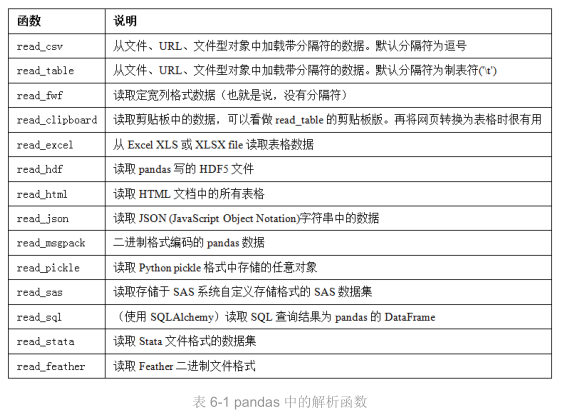

我将大致介绍一下这些函数在将文本数据转换为 DataFrame 时所用到的一些技
术。这些函数的选项可以划分为以下几个大类：

-  索引：将一个或多个列当做返回的 DataFrame 处理，以及是否从文件、用户获取列名。
-  类型推断和数据转换：包括用户定义值的转换、和自定义的缺失值标记列表等。
-  日期解析：包括组合功能，比如将分散在多个列中的日期时间信息组合成结果中的单个列。
-  迭代：支持对大文件进行逐块迭代。
-  不规整数据问题：跳过一些行、页脚、注释或其他一些不重要的东西（比如由成千上万个逗号隔开的数值数据）。

因为工作中实际碰到的数据可能十分混乱，一些数据加载函数（尤其是
read_csv）的选项逐渐变得复杂起来。面对不同的参数，感到头痛很正常
（read_csv 有超过 50 个参数）。pandas 文档有这些参数的例子，如果你感到
阅读某个文件很难，可以通过相似的足够多的例子找到正确的参数。

其中一些函数，比如 pandas.read_csv，有类型推断功能，因为列数据的类型
不属于数据类型。也就是说，你不需要指定列的类型到底是数值、整数、布尔
值，还是字符串。其它的数据格式，如 HDF5、Feather 和 msgpack，会在格式
中存储数据类型。

日期和其他自定义类型的处理需要多花点工夫才行。首先我们来看一个以逗号
分隔的（CSV）文本文件：

In [3]:
!type examples\\ex1.csv
# !cat 是 Linux 命令；！type 是 Windows 命令，注意文件目录的差异Linux \ = windows \\ = windows /

a,b,c,d,message
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


笔记：这里，我用的是 Unix 的 cat shell 命令将文件的原始内容打印到屏幕
上。如果你用的是 Windows，你可以使用 type 达到同样的效果。

由于该文件以逗号分隔，所以我们可以使用 read_csv 将其读入一个
DataFrame：

In [1]:
import pandas as pd
df = pd.read_csv('examples/ex1.csv')

In [6]:
df

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


我们还可以使用 read_table，并指定分隔符：

In [9]:
pd.read_table('examples/ex1.csv', sep=',')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [5]:
!type examples\ex2.csv

1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


读入该文件的办法有两个。你可以让 pandas 为其分配默认的列名，也可以自己
定义列名：

In [10]:
pd.read_csv('examples/ex2.csv', header=None)

,0,1,2,3,4
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [11]:
pd.read_csv('examples/ex2.csv', names=['a', 'b', 'c', 'd',
'message'])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


假设你希望将 message 列做成 DataFrame 的索引。你可以明确表示要将该列放
到索引 4 的位置上，也可以通过 index_col 参数指定"message"：

In [12]:
names = ['a', 'b', 'c', 'd', 'message']

In [13]:
pd.read_csv('examples/ex2.csv', 
            names=names,
            index_col='message')

,a,b,c,d
message,,,,
hello,1,2,3,4
world,5,6,7,8
foo,9,10,11,12


如果希望将多个列做成一个层次化索引，只需传入由列编号或列名组成的列表
即可：

In [6]:
!type examples\csv_mindex.csv

key1,key2,value1,value2
one,a,1,2
one,b,3,4
one,c,5,6
one,d,7,8
two,a,9,10
two,b,11,12
two,c,13,14
two,d,15,16


In [14]:
parsed = pd.read_csv('examples/csv_mindex.csv',
                     index_col=['key1', 'key2'])

In [15]:
parsed

value1  value2
key1 key2                
one  a          1       2
     b          3       4
     c          5       6
     d          7       8
two  a          9      10
     b         11      12
     c         13      14
     d         15      16

有些情况下，有些表格可能不是用固定的分隔符去分隔字段的（比如空白符或
其他模式）。有些表格可能不是用固定的分隔符去分隔字段的（比如空白符或
其他模式来分隔字段）。看看下面这个文本文件：

In [8]:
list(open('examples/ex3.txt'))

[' A B C\n',
 'aaa -0.264438 -1.026059 -0.619500\n',
 'bbb 0.927272 0.302904 -0.032399\n',
 'ccc -0.264273 -0.386314 -0.217601\n',
 'ddd -0.871858 -0.348382 1.100491']

虽然可以手动对数据进行规整，这里的字段是被数量不同的空白字符间隔开
的。这种情况下，你可以传递一个正则表达式作为 read_table 的分隔符。可以
用正则表达式表达为\s+，于是有有：

In [9]:
result = pd.read_table('examples/ex3.txt', sep='\s+')

In [10]:
result

,A,B,C
aaa,-0.264438,-1.026059,-0.619500
bbb,0.927272,0.302904,-0.032399
ccc,-0.264273,-0.386314,-0.217601
ddd,-0.871858,-0.348382,1.100491


这里，由于列名比数据行的数量少，所以 read_table 推断第一列应该是
DataFrame 的索引。这里，由于列名比数据行的数量少，所以 read_table 推断
第一列应该是 DataFrame 的索引。

这些解析器函数还有许多参数可以帮助你处理各种各样的异形文件格式（表 6-
2 列出了一些）。比如说，你可以用 skiprows 跳过文件的第一行、第三行和第
四行：

In [7]:
!type examples\ex4.csv

# hey!
a,b,c,d,message
# just wanted to make things more difficult for you
# who reads CSV files with computers, anyway?
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


In [11]:
pd.read_csv('examples/ex4.csv', skiprows=[0, 2, 3])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


缺失值处理是文件解析任务中的一个重要组成部分。缺失数据经常是要么没有
（空字符串），要么用某个标记值表示。默认情况下，pandas 会用一组经常出
现的标记值进行识别，比如 NA 及 NULL：

In [8]:
!type examples\ex5.csv

something,a,b,c,d,message
one,1,2,3,4,NA
two,5,6,,8,world
three,9,10,11,12,foo


In [12]:
result = pd.read_csv('examples/ex5.csv')

In [13]:
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


字典的各列可以使用不同的 NA 标记值：

In [14]:
sentinels = {'message': ['foo', 'NA'], 'something': ['two']}

In [15]:
pd.read_csv('examples/ex5.csv', na_values=sentinels)

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,NaN,5,6,NaN,8,world
2,three,9,10,11.0,12,NaN


表 6-2 列出了 pandas.read_csv 和 pandas.read_table 常用的选项。

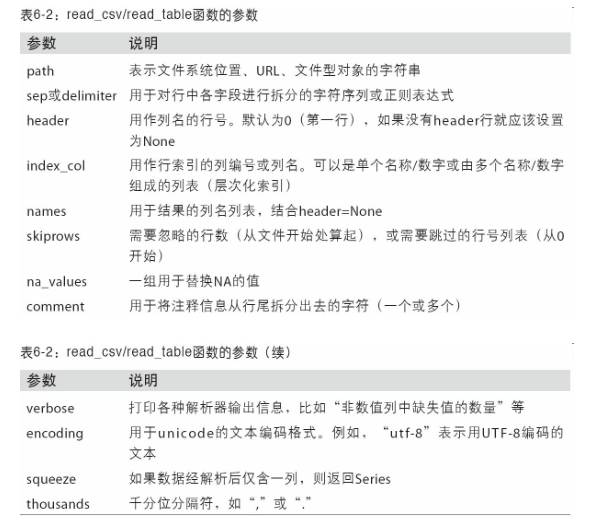

### 逐块读取文本文件

在处理很大的文件时，或找出大文件中的参数集以便于后续处理时，你可能只
想读取文件的一小部分或逐块对文件进行迭代。

在看大文件之前，我们先设置 pandas 显示地更紧些：

In [7]:
pd.options.display.max_rows = 10

In [8]:
result = pd.read_csv('examples/ex6.csv')

In [9]:
result

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q
...,...,...,...,...,...
9995,2.311896,-0.417070,-1.409599,-0.515821,L
9996,-0.479893,-0.650419,0.745152,-0.646038,E
9997,0.523331,0.787112,0.486066,1.093156,K
9998,-0.362559,0.598894,-1.843201,0.887292,G


如果只想读取几行（避免读取整个文件），通过 nrows 进行指定即可：

In [10]:
pd.read_csv('examples/ex6.csv', nrows=5)

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q


要逐块读取文件，可以指定 chunksize（行数）：

In [12]:
chunker = pd.read_csv('examples/ex6.csv', chunksize=1000)

In [13]:
chunker

read_csv 所返回的这个 TextParser 对象使你可以根据 chunksize 对文件进行
逐块迭代。比如说，我们可以迭代处理 ex6.csv，将值计数聚合到"key"列中，
如下所示：

In [14]:
chunker = pd.read_csv('examples/ex6.csv', chunksize=1000)
tot = pd.Series([])
for piece in chunker:
    tot = tot.add(piece['key'].value_counts(), fill_value=0)
    
tot = tot.sort_values(ascending=False)

In [15]:
tot[:10]

E    368.0
X    364.0
L    346.0
O    343.0
Q    340.0
M    338.0
J    337.0
F    335.0
K    334.0
H    330.0
dtype: float64

TextParser 还有一个 get_chunk 方法，它使你可以读取任意大小的块。

### 将数据写出到文本格式

数据也可以被输出为分隔符格式的文本。我们再来看看之前读过的一个 CSV 文
件：

In [3]:
data = pd.read_csv('examples/ex5.csv')

In [4]:
data

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


利用 DataFrame 的 to_csv 方法，我们可以将数据写到一个以逗号分隔的文件
中：

In [16]:
data.to_csv('examples/out.csv')

In [9]:
!type examples\out.csv

,something,a,b,c,d,message
0,one,1,2,3.0,4,
1,two,5,6,,8,world
2,three,9,10,11.0,12,foo


当然，还可以使用其他分隔符（由于这里直接写出到 sys.stdout，所以仅仅是
打印出文本结果而已）：

In [17]:
import sys
data.to_csv(sys.stdout, sep='|')

|something|a|b|c|d|message
0|one|1|2|3.0|4|
1|two|5|6||8|world
2|three|9|10|11.0|12|foo


缺失值在输出结果中会被表示为空字符串。你可能希望将其表示为别的标记
值：

In [18]:
data.to_csv(sys.stdout, na_rep='NULL')

,something,a,b,c,d,message
0,one,1,2,3.0,4,NULL
1,two,5,6,NULL,8,world
2,three,9,10,11.0,12,foo


如果没有设置其他选项，则会写出行和列的标签。当然，它们也都可以被禁
用：

In [19]:
data.to_csv(sys.stdout, index=False, header=False)

one,1,2,3.0,4,
two,5,6,,8,world
three,9,10,11.0,12,foo


此外，你还可以只写出一部分的列，并以你指定的顺序排列：

In [20]:
data.to_csv(sys.stdout, index=False, columns=['a', 'b', 'c'])

a,b,c
1,2,3.0
5,6,
9,10,11.0


Series 也有一个 to_csv 方法：

In [23]:
import numpy as np

In [24]:
dates = pd.date_range('1/1/2000', periods=7)

In [25]:
ts = pd.Series(np.arange(7), index=dates)

In [26]:
ts.to_csv('examples/tseries.csv')

In [11]:
!type examples\tseries.csv

2000-01-01,0
2000-01-02,1
2000-01-03,2
2000-01-04,3
2000-01-05,4
2000-01-06,5
2000-01-07,6


### 处理分隔符格式

大部分存储在磁盘上的表格型数据都能用 pandas.read_table 进行加载。然
而，有时还是需要做一些手工处理。由于接收到含有畸形行的文件而使
read_table 出毛病的情况并不少见。为了说明这些基本工具，看看下面这个简
单的 CSV 文件：

In [10]:
!type examples\ex7.csv

"a","b","c"
"1","2","3"
"1","2","3"


对于任何单字符分隔符文件，可以直接使用 Python 内置的 csv 模块。将任意已
打开的文件或文件型的对象传给 csv.reader：

In [13]:
import csv
f = open('examples/ex7.csv')

reader = csv.reader(f)

对这个 reader 进行迭代将会为每行产生一个元组（并移除了所有的引号）：对
这个 reader 进行迭代将会为每行产生一个元组（并移除了所有的引号）：

In [29]:
for line in reader:
    print(line)

['a', 'b', 'c']
['1', '2', '3']
['1', '2', '3']


现在，为了使数据格式合乎要求，你需要对其做一些整理工作。我们一步一步
来做。首先，读取文件到一个多行的列表中：

In [30]:
with open('examples/ex7.csv') as f:
    lines = list(csv.reader(f))

然后，我们将这些行分为标题行和数据行：

In [31]:
header, values = lines[0], lines[1:]

然后，我们可以用字典构造式和 zip(*values)，后者将行转置为列，创建数据
列的字典：

In [32]:
data_dict = {h: v for h, v in zip(header, zip(*values))}

In [33]:
data_dict

{'a': ('1', '1'), 'b': ('2', '2'), 'c': ('3', '3')}

CSV 文件的形式有很多。只需定义 csv.Dialect 的一个子类即可定义出新格式
（如专门的分隔符、字符串引用约定、行结束符等）：

In [14]:
f = open('examples/ex7.csv')
class my_dialect(csv.Dialect):
    lineterminator = '\n'
    delimiter = ';'
    quotechar = '"'
    quoting = csv.QUOTE_MINIMAL
    
reader = csv.reader(f, dialect=my_dialect)

各个 CSV 语支的参数也可以关键字的形式提供给 csv.reader，而无需定义子
类：

reader = csv.reader(f, delimiter='|')

可用的选项（csv.Dialect 的属性）及其功能如表 6-3 所示。

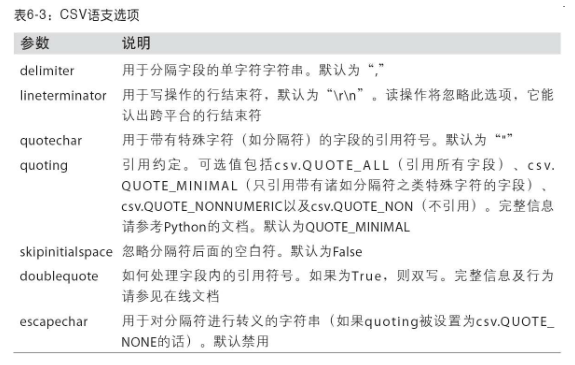

笔记：对于那些使用复杂分隔符或多字符分隔符的文件，csv 模块就无能为力
了。这种情况下，你就只能使用字符串的 split 方法或正则表达式方法
re.split 进行行拆分和其他整理工作了。

要手工输出分隔符文件，你可以使用 csv.writer。它接受一个已打开且可写的
文件对象以及跟 csv.reader 相同的那些语支和格式化选项：

In [36]:
with open('mydata.csv', 'w') as f:
    writer = csv.writer(f, dialect=my_dialect)
    writer.writerow(('one', 'two', 'three'))
    writer.writerow(('1', '2', '3'))
    writer.writerow(('4', '5', '6'))
    writer.writerow(('7', '8', '9'))

### JSON 数据

JSON（JavaScript Object Notation 的简称）已经成为通过 HTTP 请求在 Web
浏览器和其他应用程序之间发送数据的标准格式之一。它是一种比表格型文本
格式（如 CSV）灵活得多的数据格式。下面是一个例子：

In [37]:
obj = """
{"name": "Wes",
"places_lived": ["United States", "Spain", "Germany"],
"pet": null,
"siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]},
{"name": "Katie", "age": 38,
"pets": ["Sixes", "Stache", "Cisco"]}]
}
"""

除其空值 null 和一些其他的细微差别（如列表末尾不允许存在多余的逗号）之
外，JSON 非常接近于有效的 Python 代码。基本类型有对象（字典）、数组
（列表）、字符串、数值、布尔值以及 null。对象中所有的键都必须是字符
串。许多 Python 库都可以读写 JSON 数据。我将使用 json，因为它是构建于
Python 标准库中的。通过 json.loads 即可将 JSON 字符串转换成 Python 形
式：

In [38]:
import json
result = json.loads(obj)
result

{'name': 'Wes',
 'places_lived': ['United States', 'Spain', 'Germany'],
 'pet': None,
 'siblings': [{'name': 'Scott', 'age': 30, 'pets': ['Zeus', 'Zuko']},
  {'name': 'Katie', 'age': 38, 'pets': ['Sixes', 'Stache', 'Cisco']}]}

json.dumps 则将 Python 对象转换成 JSON 格式：

In [40]:
asjson = json.dumps(result)
asjson

'{"name": "Wes", "places_lived": ["United States", "Spain", "Germany"], "pet": null, "siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]}, {"name": "Katie", "age": 38, "pets": ["Sixes", "Stache", "Cisco"]}]}'

如何将（一个或一组）JSON 对象转换为 DataFrame 或其他便于分析的数据结构
就由你决定了。最简单方便的方式是：向 DataFrame 构造器传入一个字典的列
表（就是原先的 JSON 对象），并选取数据字段的子集：

In [41]:
siblings = pd.DataFrame(result['siblings'], columns=['name', 'age'])

In [42]:
siblings

,name,age
0,Scott,30
1,Katie,38


pandas.read_json 可以自动将特别格式的 JSON 数据集转换为 Series 或
DataFrame。例如：

In [12]:
!type examples\example.json

[{"a": 1, "b": 2, "c": 3},
 {"a": 4, "b": 5, "c": 6},
 {"a": 7, "b": 8, "c": 9}]


pandas.read_json 的默认选项假设 JSON 数组中的每个对象是表格中的一行：

In [43]:
data = pd.read_json('examples/example.json')
data

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


第 7 章中关于 USDA Food Database 的那个例子进一步讲解了 JSON 数据的读取
和处理（包括嵌套记录）。
如果你需要将数据从 pandas 输出到 JSON，可以使用 to_json 方法：

In [44]:
print(data.to_json())

{"a":{"0":1,"1":4,"2":7},"b":{"0":2,"1":5,"2":8},"c":{"0":3,"1":6,"2":9}}


In [45]:
print(data.to_json(orient='records'))

[{"a":1,"b":2,"c":3},{"a":4,"b":5,"c":6},{"a":7,"b":8,"c":9}]


### XML 和 HTML：Web 信息收集

Python 有许多可以读写常见的 HTML 和 XML 格式数据的库，包括 lxml、
Beautiful Soup 和 html5lib。lxml 的速度比较快，但其它的库处理有误的
HTML 或 XML 文件更好。

pandas 有一个内置的功能，read_html，它可以使用 lxml 和 Beautiful Soup
自动将 HTML 文件中的表格解析为 DataFrame 对象。为了进行展示，我从美国联
邦存款保险公司下载了一个 HTML 文件（pandas 文档中也使用过），它记录了
银行倒闭的情况。首先，你需要安装 read_html 用到的库：

In [46]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [47]:
pip install beautifulsoup4 html5lib

Note: you may need to restart the kernel to use updated packages.


pandas.read_html 有一些选项，默认条件下，它会搜索、尝试解析<table>标
签内的的表格数据。结果是一个列表的 DataFrame 对象：

In [48]:
tables = pd.read_html('examples/fdic_failed_bank_list.html')

In [49]:
len(tables)

1

In [50]:
failures = tables[0]

In [51]:
failures.head()

,Bank Name,City,ST,CERT,Acquiring Institution,Closing Date,Updated Date
0,Allied Bank,Mulberry,AR,91,Today's Bank,"September 23, 2016","November 17, 2016"
1,The Woodbury Banking Company,Woodbury,GA,11297,United Bank,"August 19, 2016","November 17, 2016"
2,First CornerStone Bank,King of Prussia,PA,35312,First-Citizens Bank & Trust Company,"May 6, 2016","September 6, 2016"
3,Trust Company Bank,Memphis,TN,9956,The Bank of Fayette County,"April 29, 2016","September 6, 2016"
4,North Milwaukee State Bank,Milwaukee,WI,20364,First-Citizens Bank & Trust Company,"March 11, 2016","June 16, 2016"


因为 failures 有许多列，pandas 插入了一个换行符\。
这里，我们可以做一些数据清洗和分析（后面章节会进一步讲解），比如计算
按年份计算倒闭的银行数：

In [52]:
close_timestamps = pd.to_datetime(failures['Closing Date'])

In [53]:
close_timestamps.dt.year.value_counts()

2010    157
2009    140
2011     92
2012     51
2008     25
       ... 
2004      4
2001      4
2007      3
2003      3
2000      2
Name: Closing Date, Length: 15, dtype: int64

### 利用 lxml.objectify 解析 XML

XML（Extensible Markup Language）是另一种常见的支持分层、嵌套数据以及
元数据的结构化数据格式。本书所使用的这些文件实际上来自于一个很大的
XML 文档。

前面，我介绍了 pandas.read_html 函数，它可以使用 lxml 或 Beautiful Soup
从 HTML 解析数据。XML 和 HTML 的结构很相似，danXML 更为通用。这里，我会
用一个例子演示如何利用 lxml 从 XML 格式解析数据。

纽约大都会运输署发布了一些有关其公交和列车服务的数据资料
（http://www.mta.info/developers/download.html）。这里，我们将看看包
含在一组 XML 文件中的运行情况数据。每项列车或公交服务都有各自的文件
（如 Metro-North Railroad 的文件是 Performance_MNR.xml），其中每条 XML
记录就是一条月度数据，如下所示：

我们先用 lxml.objectify 解析该文件，然后通过 getroot 得到该 XML 文件的根
节点的引用：

In [55]:
from lxml import objectify
path = 'datasets/mta_perf/Performance_MNR.xml'
parsed = objectify.parse(open(path))
root = parsed.getroot()

root.INDICATOR 返回一个用于产生各个<INDICATOR>XML 元素的生成器。对于每
条记录，我们可以用标记名（如 YTD_ACTUAL）和数据值填充一个字典（排除几
个标记）：

In [56]:
data = []

skip_fields = ['PARENT_SEQ', 'INDICATOR_SEQ',
               'DESIRED_CHANGE', 'DECIMAL_PLACES']

for elt in root.INDICATOR:
    el_data = {}
    for child in elt.getchildren():
        if child.tag in skip_fields:
            continue
        el_data[child.tag] = child.pyval
    data.append(el_data)

最后，将这组字典转换为一个 DataFrame：

In [57]:
perf = pd.DataFrame(data)

In [58]:
perf.head()

,AGENCY_NAME,CATEGORY,DESCRIPTION,FREQUENCY,INDICATOR_NAME,INDICATOR_UNIT,MONTHLY_ACTUAL,MONTHLY_TARGET,PERIOD_MONTH,PERIOD_YEAR,YTD_ACTUAL,YTD_TARGET
0,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,1,2008,96.9,95
1,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95,95,2,2008,96,95
2,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,3,2008,96.3,95
3,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,98.3,95,4,2008,96.8,95
4,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95.8,95,5,2008,96.6,95


XML 数据可以比本例复杂得多。每个标记都可以有元数据。看看下面这个 HTML
的链接标签（它也算是一段有效的 XML）：

In [59]:
from io import StringIO
tag = '<a href="http://www.google.com">Google</a>'
root = objectify.parse(StringIO(tag)).getroot()

现在就可以访问标签或链接文本中的任何字段了（如 href）：

In [60]:
root

<Element a at 0x186ae437ec8>

In [61]:
root.get('href')

'http://www.google.com'

In [62]:
root.text

'Google'

## 6.2 二进制数据格式

实现数据的高效二进制格式存储最简单的办法之一是使用 Python 内置的
pickle 序列化。pandas 对象都有一个用于将数据以 pickle 格式保存到磁盘上
的 to_pickle 方法：

In [63]:
frame = pd.read_csv('examples/ex1.csv')

In [64]:
frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [65]:
frame.to_pickle('examples/frame_pickle')

你可以通过 pickle 直接读取被 pickle 化的数据，或是使用更为方便的
pandas.read_pickle：

In [66]:
pd.read_pickle('examples/frame_pickle')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


注意：pickle 仅建议用于短期存储格式。其原因是很难保证该格式永远是稳定
的；今天 pickle 的对象可能无法被后续版本的库 unpickle 出来。虽然我尽力
保证这种事情不会发生在 pandas 中，但是今后的某个时候说不定还是得“打
破”该 pickle 格式。

pandas 内置支持两个二进制数据格式：HDF5 和 MessagePack。下一节，我会给
出几个 HDF5 的例子，但我建议你尝试下不同的文件格式，看看它们的速度以及
是否适合你的分析工作。pandas 或 NumPy 数据的其它存储格式有：

-  bcolz：一种可压缩的列存储二进制格式，基于 Blosc 压缩库。
-  Feather：我与 R 语言社区的 Hadley Wickham 设计的一种跨语言的列存储文件格式。Feather 使用了 Apache Arrow 的列式内存格式。

### 使用 HDF5 格式

HDF5 是一种存储大规模科学数组数据的非常好的文件格式。它可以被作为 C
库，带有许多语言的接口，如 Java、Python 和 MATLAB 等。HDF5 中的 HDF 指的
是层次型数据格式（hierarchical data format）。每个 HDF5 文件都含有一个
文件系统式的节点结构，它使你能够存储多个数据集并支持元数据。与其他简
单格式相比，HDF5 支持多种压缩器的即时压缩，还能更高效地存储重复模式数
据。对于那些非常大的无法直接放入内存的数据集，HDF5 就是不错的选择，因
为它可以高效地分块读写。

虽然可以用 PyTables 或 h5py 库直接访问 HDF5 文件，pandas 提供了更为高级
的接口，可以简化存储 Series 和 DataFrame 对象。HDFStore 类可以像字典一
样，处理低级的细节：

In [69]:
frame = pd.DataFrame({'a': np.random.randn(100)})

In [70]:
store = pd.HDFStore('mydata.h5')

In [71]:
store['obj1'] = frame

In [72]:
store['obj1_col'] = frame['a']

In [73]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: mydata.h5

HDF5 文件中的对象可以通过与字典一样的 API 进行获取：

In [74]:
store['obj1']

,a
0,1.410837
1,-1.424998
2,-1.919338
3,-0.849562
4,1.958080
...,...
95,0.945605
96,-1.936807
97,0.171228
98,-0.669637


HDFStore 支持两种存储模式，'fixed'和'table'。后者通常会更慢，但是支持
使用特殊语法进行查询操作：

In [75]:
store.put('obj2', frame, format='table')

In [76]:
store.select('obj2', where=['index >= 10 and index <= 15'])

,a
10,-0.279473
11,-0.916155
12,-1.059945
13,-1.676747
14,-1.243786
15,-0.826385


In [77]:
store.close()

put 是 store['obj2'] = frame 方法的显示版本，允许我们设置其它的选项，
比如格式。

pandas.read_hdf 函数可以快捷使用这些工具：

In [78]:
frame.to_hdf('mydata.h5', 'obj3', format='table')

In [79]:
pd.read_hdf('mydata.h5', 'obj3', where=['index < 5'])

,a
0,1.410837
1,-1.424998
2,-1.919338
3,-0.849562
4,1.958080


笔记：如果你要处理的数据位于远程服务器，比如 Amazon S3 或 HDFS，使用专
门为分布式存储（比如 Apache Parquet）的二进制格式也许更加合适。Python
的 Parquet 和其它存储格式还在不断的发展之中，所以这本书中没有涉及。
如果需要本地处理海量数据，我建议你好好研究一下 PyTables 和 h5py，看看
它们能满足你的哪些需求。。由于许多数据分析问题都是 IO 密集型（而不是
CPU 密集型），利用 HDF5 这样的工具能显著提升应用程序的效率。
注意：HDF5 不是数据库。它最适合用作“一次写多次读”的数据集。虽然数据
可以在任何时候被添加到文件中，但如果同时发生多个写操作，文件就可能会
被破坏。

### 读取 Microsoft Excel 文件

pandas 的 ExcelFile 类或 pandas.read_excel 函数支持读取存储在 Excel 2003
（或更高版本）中的表格型数据。这两个工具分别使用扩展包 xlrd 和
openpyxl 读取 XLS 和 XLSX 文件。你可以用 pip 或 conda 安装它们。
要使用 ExcelFile，通过传递 xls 或 xlsx 路径创建一个实例：

In [80]:
xlsx = pd.ExcelFile('examples/ex1.xlsx')

存储在表单中的数据可以 read_excel 读取到 DataFrame（原书这里写的是用
parse 解析，但代码中用的是 read_excel，是个笔误：只换了代码，没有改文
字）：

In [81]:
pd.read_excel(xlsx, 'Sheet1')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


如果要读取一个文件中的多个表单，创建 ExcelFile 会更快，但你也可以将文
件名传递到 pandas.read_excel：

In [82]:
frame = pd.read_excel('examples/ex1.xlsx', 'Sheet1')
frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


如果要将 pandas 数据写入为 Excel 格式，你必须首先创建一个 ExcelWriter，
然后使用 pandas 对象的 to_excel 方法将数据写入到其中：

In [83]:
writer = pd.ExcelWriter('examples/ex2.xlsx')

In [84]:
frame.to_excel(writer, 'Sheet1')

In [85]:
writer.save()

你还可以不使用 ExcelWriter，而是传递文件的路径到 to_excel：

In [86]:
frame.to_excel('examples/ex2.xlsx')

## 6.3 Web APIs 交互

许多网站都有一些通过 JSON 或其他格式提供数据的公共 API。通过 Python 访
问这些 API 的办法有不少。一个简单易用的办法（推荐）是 requests 包
（http://docs.python-requests.org）。
为了搜索最新的 30 个 GitHub 上的 pandas 主题，我们可以发一个 HTTP GET 请
求，使用 requests 扩展库：

In [87]:
import requests

In [88]:
url = 'https://api.github.com/repos/pandas-dev/pandas/issues'

In [89]:
resp = requests.get(url)

In [90]:
resp

<Response [200]>

响应对象的 json 方法会返回一个包含被解析过的 JSON 字典，加载到一个
Python 对象中：

In [91]:
data = resp.json()

In [92]:
data[0]['title']

'BUG/TST: Fillna limit Error Reporting'

data 中的每个元素都是一个包含所有 GitHub 主题页数据（不包含评论）的字
典。我们可以直接传递数据到 DataFrame，并提取感兴趣的字段：

In [93]:
issues = pd.DataFrame(data, columns=['number', 'title', 'labels', 'state'])

In [94]:
issues

,number,title,labels,state
0,27074,BUG/TST: Fillna limit Error Reporting,"[{'id': 42670965, 'node_id': 'MDU6TGFiZWw0MjY3...",open
1,27073,ENH: Json fill_value for missing fields,"[{'id': 49379259, 'node_id': 'MDU6TGFiZWw0OTM3...",open
2,27072,[POC] CLN: use ExtensionBlock for datetime tz ...,"[{'id': 849023693, 'node_id': 'MDU6TGFiZWw4NDk...",open
3,27071,BUG: preserve categorical & sparse types when ...,"[{'id': 78527356, 'node_id': 'MDU6TGFiZWw3ODUy...",open
4,27070,Add semantic analyser,"[{'id': 1280988427, 'node_id': 'MDU6TGFiZWwxMj...",open
...,...,...,...,...
25,27036,df.plot() does not work for time series after ...,"[{'id': 307649777, 'node_id': 'MDU6TGFiZWwzMDc...",open
26,27035,Unstable hashtable / duplicated algo for objec...,"[{'id': 57296398, 'node_id': 'MDU6TGFiZWw1NzI5...",open
27,27034,API/REGR: Convert to float for index union,"[{'id': 31404521, 'node_id': 'MDU6TGFiZWwzMTQw...",open
28,27033,fixes qcut failing for labels = True,"[{'id': 134699, 'node_id': 'MDU6TGFiZWwxMzQ2OT...",open


花费一些精力，你就可以创建一些更高级的常见的 Web API 的接口，返回
DataFrame 对象，方便进行分析。

## 6.4 数据库交互

在商业场景下，大多数数据可能不是存储在文本或 Excel 文件中。基于 SQL 的
关系型数据库（如 SQL Server、PostgreSQL 和 MySQL 等）使用非常广泛，其它
一些数据库也很流行。数据库的选择通常取决于性能、数据完整性以及应用程
序的伸缩性需求。

将数据从 SQL 加载到 DataFrame 的过程很简单，此外 pandas 还有一些能够简化
该过程的函数。例如，我将使用 SQLite 数据库（通过 Python 内置的 sqlite3
驱动器）：

In [15]:
import sqlite3

In [16]:
query = """
CREATE TABLE test
(a VARCHAR(20), b VARCHAR(20),
 c REAL,        d INTEGER
);"""

In [17]:
con = sqlite3.connect('mydata.sqlite')

In [21]:
con.execute(query)

OperationalError: table test already exists

In [110]:
con.commit()

然后插入几行数据：

In [100]:
data = [('Atlanta', 'Georgia', 1.25, 6),
        ('Tallahassee', 'Florida', 2.6, 3),
        ('Sacramento', 'California', 1.7, 5)]

In [111]:
stmt = "INSERT INTO test VALUES(?, ?, ?, ?)"

In [115]:
con.executemany(stmt, data)

In [116]:
con.commit()

从表中选取数据时，大部分 Python SQL 驱动器（PyODBC、psycopg2、
MySQLdb、pymssql 等）都会返回一个元组列表：

In [117]:
cursor = con.execute('select * from test')

In [118]:
rows = cursor.fetchall()

In [119]:
rows

[('Atlanta', 'Georgia', 1.25, 6),
 ('Tallahassee', 'Florida', 2.6, 3),
 ('Sacramento', 'California', 1.7, 5)]

你可以将这个元组列表传给 DataFrame 构造器，但还需要列名（位于光标的
description 属性中）：

In [120]:
cursor.description

(('a', None, None, None, None, None, None),
 ('b', None, None, None, None, None, None),
 ('c', None, None, None, None, None, None),
 ('d', None, None, None, None, None, None))

In [121]:
pd.DataFrame(rows, columns=[x[0] for x in cursor.description])

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5


这种数据规整操作相当多，你肯定不想每查一次数据库就重写一次。
SQLAlchemy 项目是一个流行的 Python SQL 工具，它抽象出了 SQL 数据库中的
许多常见差异。pandas 有一个 read_sql 函数，可以让你轻松的从 SQLAlchemy
连接读取数据。这里，我们用 SQLAlchemy 连接 SQLite 数据库，并从之前创建
的表读取数据：

In [122]:
import sqlalchemy as sqla

In [123]:
db = sqla.create_engine('sqlite:///mydata.sqlite')

In [124]:
pd.read_sql('select * from test', db)

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5


## 6.5 总结

访问数据通常是数据分析的第一步。在本章中，我们已经学了一些有用的工
具。在接下来的章节中，我们将深入研究数据规整、数据可视化、时间序列分
析和其它主题。